# Logistic regression using `scikit-learn`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm, metrics, model_selection as ms

%matplotlib inline

Read in the [Bank Marketing](https://archive.ics.uci.edu/ml/datasets/bank+marketing) dataset.

In [2]:
bank = pd.read_csv("datasets/bank-marketing.csv", sep=";")

Select a few variables as predictors.

In [3]:
X = pd.get_dummies(bank[["age", "job", "default", "housing", "loan"]], drop_first=True)
y = (bank["y"] == "yes").astype("int")

## Logistic regression

Fit the model.

**Note**: by default, `scikit-learn` uses $L_{2}$ regularisation with parameter `C` (default = 1). This cannot be disabled, but we can set `C` so big that it has little effect.

In [4]:
model = lm.LogisticRegression(C=1e50, solver="liblinear")
model.fit(X, y)

LogisticRegression(C=1e+50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Print regression coefficients.

In [5]:
model.coef_

array([[ 0.00870061, -0.55399519, -0.45534282, -0.23234851, -0.18775122,
         0.68877087, -0.20927852, -0.45042672,  1.22337584, -0.19743081,
         0.16475846,  0.01927888, -0.95088948, -0.0115489 , -0.00507729,
         0.06069263, -0.00507729, -0.05362445]])

Print variable names and odds ratios.

In [6]:
list(zip(X.columns, np.exp(model.coef_[0,:])))

[('age', 1.008738568963076),
 ('job_blue-collar', 0.5746493865764701),
 ('job_entrepreneur', 0.6342305028672086),
 ('job_housemaid', 0.7926698219378892),
 ('job_management', 0.8288208759473542),
 ('job_retired', 1.991266510387734),
 ('job_self-employed', 0.811169274276484),
 ('job_services', 0.637356122476304),
 ('job_student', 3.3986416477917385),
 ('job_technician', 0.8208369348633375),
 ('job_unemployed', 1.1791082823517949),
 ('job_unknown', 1.0194659164291986),
 ('default_unknown', 0.386397179512699),
 ('default_yes', 0.9885175346715102),
 ('housing_unknown', 0.9949355817156411),
 ('housing_yes', 1.0625722602093428),
 ('loan_unknown', 0.9949355817156411),
 ('loan_yes', 0.9477879824611014)]

Compute classification accuracy.

In [7]:
metrics.accuracy_score(y, model.predict(X))

0.8873458288821987

Compute confusion matrix.

In [8]:
metrics.confusion_matrix(y, model.predict(X))

array([[36548,     0],
       [ 4640,     0]])

What happened‽ The accuracy we got is the same as the proportion of negative observations!

In [9]:
1 - y.mean()

0.8873458288821987

We can fix this by setting `class_weight` to `balanced`.

In [10]:
model = lm.LogisticRegression(C=1e50, class_weight="balanced", solver="liblinear")
model.fit(X, y)

LogisticRegression(C=1e+50, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [11]:
metrics.accuracy_score(y, model.predict(X))

0.5344517820724483

In [12]:
metrics.confusion_matrix(y, model.predict(X))

array([[18883, 17665],
       [ 1510,  3130]])

## ROC analysis

Compute predicted probabilities.

In [13]:
pred_probs = model.predict_proba(X)[:,1]

Visualise distribution.

/home/gc/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


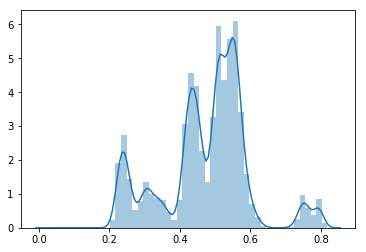

In [14]:
sns.distplot(pred_probs)

Plot the ROC curve.

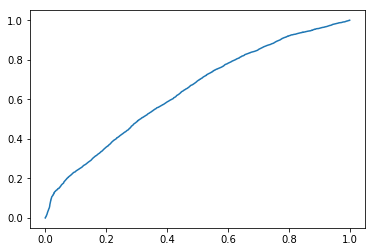

In [15]:
fpr, tpr, cutoffs = metrics.roc_curve(y, pred_probs)
plt.plot(fpr, tpr)

Compute area under the ROC curve (AUC).

In [16]:
metrics.roc_auc_score(y, pred_probs)

0.6407148853373741

## Cross-validation

Define stratified folds.

In [17]:
cv = ms.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Compute average classification accuracy across folds.

In [18]:
estimator = lm.LogisticRegression(C=1e50, class_weight="balanced", solver="liblinear")
accuracies = ms.cross_val_score(estimator, X, y, scoring="accuracy", cv=cv)
np.mean(accuracies)

0.5385557349504909

Compute average AUC across folds.

In [19]:
aucs = ms.cross_val_score(estimator, X, y, scoring="roc_auc", cv=cv)
np.mean(aucs)

0.6381634772901723

## Regularisation

Determine 'optimal' value of `C` by cross-validation using AUC scoring
(`scikit-learn` uses $L_{2}$ regularisation by default).

In [20]:
gs = ms.GridSearchCV(estimator,
                     param_grid={"C": np.logspace(-4, 4, 11)},
                     scoring="roc_auc",
                     cv=cv)
gs.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1e+50, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-04, 6.30957e-04, 3.98107e-03, 2.51189e-02, 1.58489e-01,
       1.00000e+00, 6.30957e+00, 3.98107e+01, 2.51189e+02, 1.58489e+03,
       1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [21]:
gs.best_score_

0.6388265204655146

In [22]:
gs.best_estimator_

LogisticRegression(C=0.025118864315095822, class_weight='balanced',
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

Plot `C`s against AUC scores.

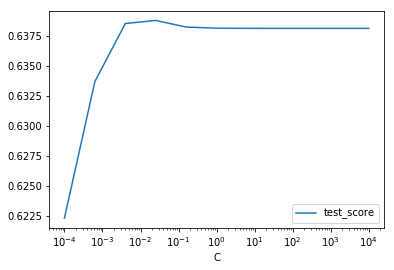

In [23]:
cv_results = pd.DataFrame({**gs.param_grid,
                           **{"test_score": gs.cv_results_["mean_test_score"]}})
cv_results.plot(x="C", y="test_score", logx=True)